# Advanced usage

In this notebook we will go a bit deeped into internal structures of the `semantique` package. We will also show some common operations for advanced users, that want more control over the behaviour of the query processor, and extend built-in structures of the package. It is assumed that you are already quite familiar with the structure and contents of the package, for example by reading the other provided notebooks.

## Content

- [The query processor class](#The-query-processor-class)
- [Creating a spatio-temporal extent cube](#Creating-a-spatio-temporal-extent-cube)
- [Tracking value types](#Tracking-value-types)
- [Adding custom operators](#Adding-custom-operators)
- [Adding custom reducers](#Adding-custom-reducers)
- [Tuning factbase configuration settings](#Tuning-factbase-configuration-settings)
- [Creating custom factbase classes](#Creating-custom-factbase-classes)
- [Creating custom ontology classes](#Creating-custom-ontology-classes)

## Prepare

Import the `semantique` package:

In [32]:
import semantique as sq

Import other packages we will use in this demo:

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import copy
import json
import inspect

Create the components for query processing. See the [Intro notebook](intro.ipynb) for details.

In [34]:
# Query recipe.
with open("files/recipe.json", "r") as file:
    recipe = sq.QueryRecipe(json.load(file))

# Ontology.
with open("files/ontology.json", "r") as file:
    ontology = sq.ontology.Semantique(json.load(file))

# Factbase.
with open("files/factbase.json", "r") as file:
    factbase = sq.factbase.GeotiffArchive(json.load(file), src = "files/resources.zip")

# Extent.
space = sq.SpatialExtent(gpd.read_file("files/footprint.geojson"))
time = sq.TemporalExtent("2019-01-01", "2020-12-31")

# Additional configuration.
config = {"crs": 3035, "tz": "UTC", "spatial_resolution": [-10, 10]}

## The query processor class

A semantic query is processed by a query processor. In `semantique`, this query processor is internally modelled as an object of class `QueryProcessor`. An instance of this class is initialized whenever a query recipe is executed with respect to a given factbase, ontology and spatio-temporal extent. That is, whenever you call the execute method of a `QueryRecipe` instance, semantique internally creates a `QueryProcessor` object to take care of all processing tasks.

In [35]:
from semantique.processor.core import QueryProcessor

The query processor processes a query in three three core phases: query parsing, query optimization and query execution. These align with the common phases in regular relational database querying (see for example [this paper](https://dsf.berkeley.edu/papers/fntdb07-architecture.pdf)). Each of these phases has their own, dedicated method. Below we will explain in more detail how each phase is implemented in `semantique`.

### Query parsing

During query parsing, the required components for processing (i.e., the query recipe, the spatial and temporal extents, the ontology, the factbase and the additional configuration parameters) are read and converted all together into a single object which will be used internally for further processing of the query. This object is called the query processor. Parsing should take care of validating the components and their interrelations. For example, it will check if referenced concepts in the query statement are actually defined in the ontology. A specific task of the query parser in `semantique` is also to combine the spatial and temporal extent of the query into a single spatio-temporal extent cube, see [here](#Creating-a-spatio-temporal-extent-cube) for details.

Parsing is implemented as a [classmethod](https://www.programiz.com/python-programming/methods/built-in/classmethod) of the `QueryProcessor` class. Hence, it can be used directly to construct a `QueryProcessor` instance given the components mentioned above.

> **NOTE** <br/> Currently the actual implementation of the query parsing phase is still very basic in its functionalities. It initializes the internal query processor object, but does not validate the query components yet.

In [36]:
processor = QueryProcessor.parse(recipe, factbase, ontology, space, time, **config)

In [37]:
type(processor)

semantique.processor.core.QueryProcessor

### Query optimization

During query optimization, the query processor is scanned and an execution plan is written. The execution plan is a step-by-step guide of how the query should be executed during the execution phase that follows. Creating this causes some overhead, but that should be balanced out by considerably faster execution times. For example, if the given spatial extent consists of multiple dispersed sub-areas, the execution plan might instruct the execution phase to load data separately for each sub-area, instead of loading data for the full extent and then subset it afterwards. 

Optimization is implemented as a method of the `QueryProcessor` class, and returns the same instance, but with a query execution plan added to it.

> **NOTE** <br/> Currently the actual implementation of the query optimization phase is still very basic in its functionalities. To be honest, it currently does exactly nothing. That is, the query will be executed ‘as-is’, and not yet according to an optimized query execution plan. The function is merely provided as a placeholder for a future implementation of query optimization.

In [38]:
processor = processor.optimize()

In [39]:
type(processor)

semantique.processor.core.QueryProcessor

### Query execution

Finally, the execution phase follows the execution plan and executes all result instructions. The query processor instance contains specific handlers for all kind of operations that may be specified in the execution plan. Internally it will take care of the interaction with (and between) the given ontology and factbase, and forward required parameters to their translator and retriever accordingly.

Execution is modelled as a method of the `QueryProcessor` class, and returns the same instance, but with a filled response property containing all executed result instructions as `xarray.DataArray` objects.

In [40]:
# Before execution the response property is empty.
processor.response

{}

In [41]:
processor = processor.execute()

In [42]:
type(processor)

semantique.processor.core.QueryProcessor

In [43]:
# After execution the response property is filled.
processor.response

{'water_count_map': <xarray.DataArray 'water_count_map' (space: 324288)>
 array([1., 1., 1., ..., 0., 0., 0.])
 Coordinates:
     spatial_ref   int64 0
     temporal_ref  int64 0
   * space         (space) MultiIndex
   - y             (space) float64 2.697e+06 2.697e+06 ... 2.691e+06 2.691e+06
   - x             (space) float64 4.53e+06 4.53e+06 ... 4.536e+06 4.536e+06
     feature       (space) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
 Attributes:
     value_type:  numerical,
 'vegetation_count_map': <xarray.DataArray 'vegetation_count_map' (space: 324288)>
 array([1., 1., 1., ..., 1., 1., 1.])
 Coordinates:
     spatial_ref   int64 0
     temporal_ref  int64 0
   * space         (space) MultiIndex
   - y             (space) float64 2.697e+06 2.697e+06 ... 2.691e+06 2.691e+06
   - x             (space) float64 4.53e+06 4.53e+06 ... 4.536e+06 4.536e+06
     feature       (space) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
 Attributes:
     value_type:  numerical,
 '

When executing a query recipe, the `QueryProcessor` moves through the building blocks of the result instructions. For each building block, it has a specific **handler function** implemented as a method. Whenever the processor reaches a new block, it looks up its type and then calls its handler with the `call_handler` method.

For example, when the processor stumbles upon a reference to a semantic concept, it forwards it to the `call_handler` function, which will notice this is a block of type "concept", and therefore call the handler `handle_concept`. This handler knows exactly what to do with this type of block. In this specific example, it calls the translator function of the provided ontology to obtain the boolean data cube belonging to the referenced concept. Note that this example makes it extra clear that the query processor does not care *how* the reference is translated. It only cares about the parameters the translator function accepts, and about the type of object it returns (which should be an `xarray.DataArray`).

In [44]:
print(inspect.getsource(processor.handle_concept))

  def handle_concept(self, block):
    """Handler for semantic concept references.

    Parameters
    ----------
      block : :obj:`dict`
        Textual representation of a building block of type "concept".

    Returns
    -------
      :obj:`xarray.DataArray`

    """
    out = self._ontology.translate(
      *block["reference"],
      property = block["property"] if "property" in block else None,
      extent = self._extent,
      factbase = self._factbase,
      eval_obj = self._get_eval_obj(),
      operators = self._operators,
      reducers = self._reducers,
      track_types = self._track_types,
      trim_filter = self._trim_filter
    )
    return out



In [45]:
water = processor.handle_concept(sq.entity("water"))

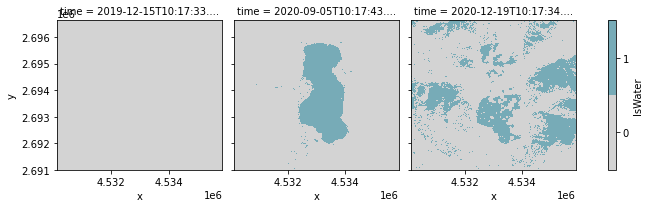

In [46]:
values = [0, 1]
levels = [x - 0.5 for x in values + [max(values) + 1]]
colors = ["#d3d3d3", "#77abb7"]
legend = {"ticks": values, "label": "IsWater"}
water.unstack().plot(col = "time", levels = levels, colors = colors, cbar_kwargs = legend)

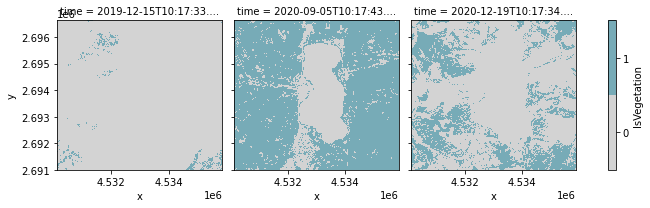

In [47]:
vegetation = processor.handle_concept(sq.entity("vegetation"))
legend = {"ticks": values, "label": "IsVegetation"}
vegetation.unstack().plot(col = "time", levels = levels, colors = colors, cbar_kwargs = legend)

Another example: when the processor stumbles upon a processing chain, it forwards it to the `call_handler` function, which will notice this is a block of type "chain", and therefore call the handler `handle_chain`. This handler knows exactly what to do with this type of block. It first moves into the *with* part of the chain, and processes the reference (or a nested processing chain) it finds there by calling the corresponding handler. Then, it sets the obtained data cube (represented as `xarray.DataArray` object) as the new active evaluation object, and moves into the *do* part of the chain. For each verb, it calls the handler corresponding to that verb, which knows exactly how to apply that verb to a data cube (this is explained in more detail in the [Verbs notebook](verbs.ipynb)). Et cetera.

In [48]:
print(inspect.getsource(processor.handle_processing_chain))

  def handle_processing_chain(self, block):
    """Handler for processing chains.

    Parameters
    ----------
      block : :obj:`dict`
        Textual representation of a building block of type "processing_chain".

    Returns
    -------
      :obj:`xarray.DataArray` or :obj:`CubeCollection <semantique.processor.structures.CubeCollection>`

    """
    obj = self.call_handler(block["with"])
    self._set_eval_obj(obj)
    for i in block["do"]:
      out = self.call_handler(i)
    self._reset_eval_obj()
    return out



In [49]:
chain = sq.entity("water").\
    filter_time("year", "equal", 2020).\
    evaluate("or", sq.entity("vegetation"))

out = processor.handle_processing_chain(chain)

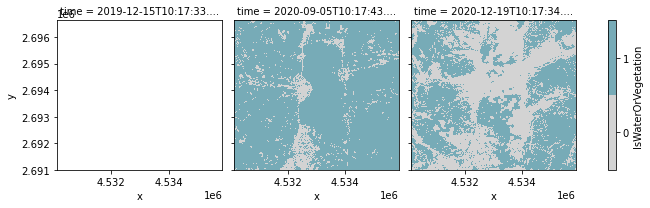

In [50]:
values = [0, 1]
levels = [x - 0.5 for x in values + [max(values) + 1]]
legend = {"ticks": values, "label": "IsWaterOrVegetation"}
out.unstack().plot(col = "time", levels = levels, colors = colors, cbar_kwargs = legend)

Some of the verbs accept other building blocks as their parameters. For example, the `filter` verb, as shown above, requires the `filterer` parameter to be a binary data cube, which can be constructed inside a nested processing chain. However, in the block structure, this is still nothing more than a textual reference. Hence, for some verbs, its parameters need to be parsed before applying the actual verb to the input data cube. The query processor uses the `parse_params_of_*` set of functions to take care of this. It also specifies additional parameters to be forwarded to the filter function, such as if it needs to keep track of value types or not (see [Tracking value types](#Tracking-value-types)).

For example:

In [51]:
verb = sq.entity("water").filter(sq.self().extract("time", "year").evaluate("equal", 2020))["do"][0]
verb

{'type': 'verb',
 'name': 'filter',
 'params': {'filterer': {'type': 'processing_chain',
   'with': {'type': 'self'},
   'do': [{'type': 'verb',
     'name': 'extract',
     'params': {'dimension': 'time', 'component': 'year'}},
    {'type': 'verb',
     'name': 'evaluate',
     'params': {'operator': 'equal', 'y': 2020}}]}}}

In [52]:
verb["params"] = processor.parse_params_of_filter(verb["params"])
verb

{'type': 'verb',
 'name': 'filter',
 'params': {'filterer': <xarray.DataArray (time: 2)>
  array([0., 1.])
  Coordinates:
    * time          (time) datetime64[ns] 2019-01-01 2020-12-31
      spatial_ref   int64 0
      temporal_ref  int64 0
  Attributes:
      value_type:  binary,
  'trim': False,
  'track_types': True}}

### Query response

To actually make the query processor return the response, you have to call the `respond` method of the `QueryProcessor` instance. Before returning the result arrays, this method will first post-process them.

One of the post-processing steps is *trimming* the result arrays. This means that all coordinates for which all values are nodata, are dropped from the array. The spatial dimension (if present) is treated differently, by trimming it only at the edges, and thus maintaining the regularity of the spatial dimension.

Trimming results can be disabled by adding the configuration parameter "trim_results" when initializing the query processor, and set its value to "False".

```python
config["trim_results"] = False
```

Note the difference:

In [53]:
new_recipe = sq.QueryRecipe()
new_config = copy.deepcopy(config)

new_recipe["foo"] = sq.entity("water").filter_time("year", "equal", 2020)

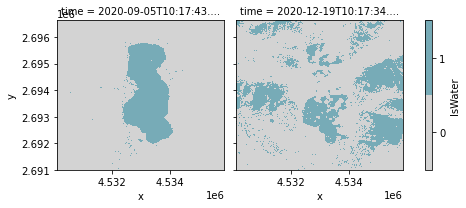

In [54]:
out = new_recipe.execute(factbase, ontology, space, time, **new_config)["foo"]

values = [0, 1]
levels = [x - 0.5 for x in values + [max(values) + 1]]
legend = {"ticks": values, "label": "IsWater"}
out.unstack().plot(col = "time", levels = levels, colors = colors, cbar_kwargs = legend)

In [55]:
new_config["trim_results"] = False

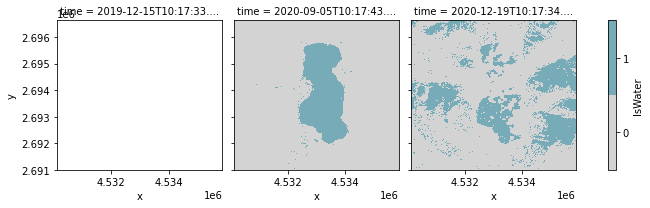

In [56]:
out = new_recipe.execute(factbase, ontology, space, time, **new_config)["foo"]

values = [0, 1]
levels = [x - 0.5 for x in values + [max(values) + 1]]
legend = {"ticks": values, "label": "IsWater"}
out.unstack().plot(col = "time", levels = levels, colors = colors, cbar_kwargs = legend)

Another post-processing step is *unstacking* the result arrays. Internally the query processor always works with arrays that have a stacked spatial dimension, meaning the the x and y dimension are stacked together into a single multi-indexed space dimension. Before responding, the query processor unstacks the space dimension, such that the returned arrays have separate x and y dimensions again.

Unstacking results can be disabled by adding the configuration parameter "unstack_results" when initializing the query processor, and set its value to "False".

```python
config["unstack_results"] = False
```

Note the difference:

In [57]:
new_recipe = sq.QueryRecipe()
new_config = copy.deepcopy(config)

new_recipe["foo"] = sq.entity("water").filter_time("year", "equal", 2020)

In [58]:
out = new_recipe.execute(factbase, ontology, space, time, **new_config)["foo"]
print(out)

<xarray.DataArray 'foo' (time: 2, y: 563, x: 576)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time          (time) datetime64[ns] 2020-09-05T10:17:43.167942 2020-12-19...
    spatial_ref   int64 0
    temporal_ref  int64 0
    feature       (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
  * y             (y) float64 2.697e+06 2.697e+06 ... 2.691e+06 2.691e+06
  * x             (x) float64 4.53e+06 4.53e+06 4.53e+06 ... 4.536e+06 4.536e+06
Attributes:
    value_type:  binary


In [59]:
new_config["unstack_results"] = False

In [60]:
out = new_recipe.execute(factbase, ontology, space, time, **new_config)["foo"]
print(out)

<xarray.DataArray 'foo' (time: 2, space: 324288)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])
Coordinates:
  * time          (time) datetime64[ns] 2020-09-05T10:17:43.167942 2020-12-19...
    spatial_ref   int64 0
    temporal_ref  int64 0
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
  * space         (space) MultiIndex
  - y             (space) float64 2.697e+06 2.697e+06 ... 2.691e+06 2.691e+06
  - x             (space) float64 4.53e+06 4.53e+06 ... 4.536e+06 4.536e+06
Attributes:
    value_type:  binary


## Creating a spatio-temporal extent cube

Internally the query processor uses a single multi-dimensional array to represent the spatio-temporal extent of the query. This is an `xarray.DataArray` object and forms the base template for all cubes that are fetched from the factbase during query processing. It is created during the [query parsing](#Query-parsing) phase, using a specific function named `create_extent_cube`. 

The array is constructed as follows:

1) The spatial extent is *reprojected* and *rasterized* given the specified coordinate reference system and spatial resolution in the configuration parameters. The resulting array is always rectangular and therefore covers the full *bounding box* of the area that was orginally given as spatial extent. Cells that don't overlap with the area boundaries itself are filled with nodata values (i.e. `nan`). Others are filled with an integer. If the given area consisted of a single feature, they are all filled with a value of `1`. If the given area consisted of multiple disconnected features, each feature gets a different index value.

2) The two spatial dimensions are *stacked* together into a single "space" dimension. This dimension has as many coordinates as the number of cells in the trimmed spatial array. Each coordinate value is a tuple of the x and y coordinate of the corresponding cell.

3) This stacked spatial array is *expanded* over a time dimension. The time dimension has two coordinates: the first coordinate value corresponds to the timestamp at the start of the given time interval, and the second coordinate value corresponds to the timestamp at the end of the given time interval. The time values are *converted* into the specified time zone in the configuration parameters.

4) The spatio-temporal array is *trimmed*, meaning that all coordinates for which all pixel values are nodata, are removed from the array. The spatial dimension (if present) is treated differently, by trimming it only at the edges, and thus maintaining the regularity of the spatial dimension.

You can call the `create_extent_cube` function directly to create a spatio-temporal extent cube from respectively a spatial and temporal extent. It may occur that due to the reprojection of the provided spatial extent, some pixels at the edges of the extent get a nodata value.

In [61]:
from semantique.processor.utils import create_extent_cube

In [62]:
crs = config["crs"]
tz = config["tz"]
res = config["spatial_resolution"]
extent = create_extent_cube(space, time, res, crs = crs, tz = tz)

In [63]:
print(extent)

<xarray.DataArray 'index' (time: 2, space: 324288)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * time          (time) datetime64[ns] 2019-01-01 2020-12-31
    spatial_ref   int64 0
    feature       (space) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    temporal_ref  int64 0
  * space         (space) MultiIndex
  - y             (space) float64 2.697e+06 2.697e+06 ... 2.691e+06 2.691e+06
  - x             (space) float64 4.53e+06 4.53e+06 ... 4.536e+06 4.536e+06
Attributes:
    name:          index
    long_name:     index
    _FillValue:    nan
    value_type:    nominal
    value_labels:  {'feature_1': 1}


Complying with common standards (see e.g. the discussion [here](https://github.com/opendatacube/datacube-core/issues/837)), the coordinate reference system of the spatial coordinates is stored as attribute of a specific non-dimension coordinate named "spatial_ref". Storing this inside a non-dimension coordinate instead of as direct attribute of the array guarantees that this information is preserved during any kind of operation. The coordinate itself serves merely as a placeholder.

In [64]:
print(extent["spatial_ref"].attrs)

{'crs_wkt': 'PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","3035"]]', 'semi_major_axis': 6378137.0, 'semi_minor_axis': 6356752.314140356, 'inverse_flattening': 298.257222101, 'reference_ellipsoid_name': 'GRS 1980', 'longitude_of_prime_meridian': 0.0, 'prime_meridian_name': 'Greenwich', 'geographic_crs_name': 'ETRS89', 'horizontal_datum_name': 'European Terrestrial Reference System 1989', 'projected_crs_name': 'ETRS89-extend

In the same style, `semantique` stores time zone information as attribute of a non-dimension coordinate named "temporal_ref". Note that time coordinates themselves are stored as `numpy.datetime64` objects, which in itself don't support timezone information anymore. Therefore, the "temporal_ref" coordinate is an important piece of information in the spatio-temporal extent cube.

In [65]:
print(extent["temporal_ref"].attrs)

{'zone': 'UTC'}


The query processor obtains such spatio-temporal information by calling specific properties of the array, rather than scanning the above-mentioned non-dimension coordinates directly.

> **NOTE** <br/> `semantique` extends regular `xarray.DataArray` objects with an accessor named `sq`. Therefore, `semantique` specific array methods are always called as `sq.methodname`. Using accessors instead of the common class inheritance is recommended by the developers of `xarray`. Read more about it [here](http://xarray.pydata.org/en/stable/internals/extending-xarray.html).

In [66]:
extent.sq.crs

CRS.from_epsg(3035)

In [67]:
type(extent.sq.crs)

rasterio.crs.CRS

In [68]:
extent.sq.tz

<UTC>

In [69]:
type(extent.sq.tz)

pytz.UTC

In [70]:
extent.sq.spatial_resolution

(-10.0, 10.0)

## Tracking value types

During query processing references get translated into data cubes, and these data cubes are wrangled by specified actions. Along this road, the query processor keeps track of the *value type* of each data cube. Such a value type describes what kind of data the cube contains. It differs from the very technical, computer-oriented `numpy.dtype` categorization, which contains e.g. `int`, `float`, etc. Instead, the *value type* describes data on a more general, statistical level.  Currently it makes a distinction between three main value types:

- Numerical
- Nominal
- Ordinal
- Binary

It is expected that whenever a data cube is retrieved from the factbase, the corresponding value type is stored as an array attribute named "value_type". Even when the data are not qualitative, they are usually stored as numbers. In these cases, an additional attribute named "value_labels" may be used to define the mapping between character-encoded *labels* and integer-encoded *indices*.

If a data cube does not contain these attributes, the value type is considered to be `None`, which in practice means that the query processor assumes it can be any of the supported value types.

In [71]:
colors = factbase.retrieve("appearance", "Color type", extent = extent)

In [72]:
colors.sq.value_type

'ordinal'

In [73]:
colors.sq.value_labels

{'SVHNIR': 1,
 'SVLNIR': 2,
 'AVHNIR': 3,
 'AVLNIR': 4,
 'WV': 5,
 'SHV': 6,
 'SHRBRHNIR': 7,
 'SHRBRLNIR': 8,
 'HRBCR': 9,
 'WR': 10,
 'PB': 11,
 'GH': 12,
 'VBBB': 13,
 'BBB': 14,
 'SBB': 15,
 'ABB': 16,
 'DBB': 17,
 'WBBorSHB': 18,
 'NIRPBB': 19,
 'BA': 20,
 'DPWASH': 21,
 'SLWASH': 22,
 'TWASH': 23,
 'SASLWA': 24,
 'TNCLV': 27,
 'TNCLWA_BB': 28,
 'SN': 29,
 'SHSN': 30,
 'SH': 31,
 'FLAME': 32}

In [74]:
water = ontology.translate("entity", "water", extent = extent, factbase = factbase)

In [75]:
water.sq.value_type

'binary'

Whenever applying actions to a data cube, its value type might change. For example, when evaluating an expression (e.g. when evaluating an expression involving a comparison operator the resulting values are always binary) or applying a reducer (e.g. when counting the number of "true" values in a binary data cube the resulting values are numerical). This is what we also call **type promotion**. Each implemented operator and reducer function is able to promote the type of the output given the type(s) of the input(s) by using a type promotion manual. Most of the times this manual is not constructed inside the function itself, but a pre-defined template is used instead.

A common type promotion manual for a univariate operator and a reducer has a dictionary structure with as keys the supported input value types. The value of each key is the output value type. For example, the `count` reducer should only be applied to data cubes containing binary data, since it counts the number of "true" values. The output of that operation, however, is a data cube with numerical data. Hence, the corresponding type promotion manual looks like this:

In [76]:
from semantique.processor.templates import TYPE_PROMOTION_TEMPLATES

In [77]:
TYPE_PROMOTION_TEMPLATES["count_reducers"]

{'binary': 'numerical', None: None, '__preserve_labels__': False}

The additional key `__preserve_labels__` defines if value labels should be preserved after the reducer is applied.

The reduction function will apply the type promotion whenever argument `track_types` is set to `True`. When we apply the count reducer to a binary data cube, this means the value type of the output will be numerical:

In [78]:
from semantique.processor import reducers

In [79]:
new = water.sq.reduce("time", reducers.count_, track_types = True)
new.sq.value_type

'numerical'

Now, when we call this reducer function on e.g. an ordinal data cube instead of a binary data cube, an `InvalidValueTypeError` will be thrown. Hence, the query processor uses type tracking also to *check* type promotions, and thus, to detect invalid operations.

In [80]:
from semantique.exceptions import InvalidValueTypeError

In [81]:
try:
    colors.sq.reduce("time", reducers.count_, track_types = True)
except InvalidValueTypeError as e:
    print(e)

Unsupported operand value type(s) for 'count': '['ordinal']'


This will not happen when `track_types = False`. In that case, value types are not tracked and the output cube has no value type at all.

In [82]:
new = colors.sq.reduce("time", reducers.count_, track_types = False)
"value_type" in new.attrs

False

For multivariate expressions, the type promotion manuals have an extra "layer" per additional operand. For expressions with two operands, that means that the first layer of keys refers to the value type of the first operand (i.e. x) and the second layer of keys to the value type of the second operand (i.e. y). For example, the boolean operator `and` accepts only data cubes with binary values, and returns binary values as well. Hence, the corresponding type promotion manual looks like this:

In [83]:
TYPE_PROMOTION_TEMPLATES["boolean_multivariate_operators"]

{'binary': {'binary': 'binary', 'b': 'binary', None: None},
 None: {'binary': None, 'b': None, None: None},
 '__preserve_labels__': True}

When `track_types = True`, the operator function will apply the type promotion. Also here, providing data cubes with an unsupported value type for this operation results in an `InvalidValueTypeError`.

In [84]:
from semantique.processor import operators

In [85]:
new = water.sq.evaluate(operators.and_, water, track_types = True)
new.sq.value_type

'binary'

In [86]:
try:
    colors.sq.evaluate(operators.and_, water, track_types = True)
except InvalidValueTypeError as e:
    print(e)

Unsupported operand value type(s) for 'and': '['ordinal', 'binary']'


In the type promotion manual of the `and` operator we see something interesting: the occurence "b" in the second layer of keys. This is there since the second operand in the evaluate verb can also be a single value or a list of values instead of a data cube. For such values, we use regular numpy dtypes to check types. In numpy, the [character code](https://numpy.org/doc/stable/reference/generated/numpy.dtype.kind.html) "b" refers to boolean values, and are therefore accepted as second operand in an expression involving a logical operator like `and`.

In [87]:
new = water.sq.evaluate(operators.and_, True, track_types = True)
new.sq.value_type

'binary'

Next to the main value types, there are two special value types we did not touch upon yet. These are *time* for timestamps and *space* for tuples of (x, y)-coordinates. These additional value types are added to support specific temporal (e.g. during, after) and spatial (e.g. intersects) operators. For example, the temporal operator `during` only accepts data cubes containing timestamps (usually such cubes are obtained by extracting dimension coordinates from a retrieved data cube), and possibly datetime objects (character code "M") as second operand.

In [88]:
TYPE_PROMOTION_TEMPLATES["temporal_relational_operators"]

{'time': {'time': 'binary', 'M': 'binary', None: None},
 None: {'time': None, 'M': None, None: None},
 '__preserve_labels__': False}

Now what if you don't want the query processor to track types at all? There are several reasons why you'd want to do so. For example, type tracking can be so strict that it limits your flexibility of using certain processes "out of the box". Some custom factbases you use may not set value types at all, and some custom operators or reducers that you use may not have any type promotion manual. Also, type tracking of course takes time and thus decreases query performance. No worries, it is easy to tell the query processor to *not* track types. Simply add the configuration parameter "track_types" when initializing the query processor, and set its value to "False":

```python
config["track_types"] = False
```

## Adding custom operators

Operators are used when evaluating expressions on data cubes with the [evaluate verb](verbs.ipynb#Evaluate). For example, you can compare each value in a data cube with a given constant (using e.g. the `greater`, `equal` or `less` operators), add two data cubes together (using the `add` operator), etcetera. When creating a query recipe, you can refer to these operators by their name, for example:

```python
sq.result("water_count").evaluate("multiply", 2)
```

The query processor instance has a `operators` property in 
which it stores all supported operator functions. The keys of this dictionary are the operator names, such that the query processor can quickly retrieve the corresponding function of any referenced operator in the query recipe. For example:

In [89]:
processor.operators["multiply"]

<function semantique.processor.operators.multiply_(x, y, track_types=False, **kwargs)>

As can be seen, the operator function itself is taken from the [operators module](semantique/processor/operators.py) of `semantique`. This is the module in which all built-in operator functions are defined. When initializing a query processor with default settings, these are the operators that get stored in the processors `operators` property.

In [90]:
for x in processor.operators.keys():
    print(x)

absolute
add
after
and
assign
before
cube_root
divide
during
equal
exclusive_or
greater
greater_equal
in
invert
less
less_equal
multiply
natural_logarithm
not_equal
not_in
or
power
square_root
subtract


That all operator functions are stored inside a property of the query processor means that you can easily overwrite them with your own custom operator functions (or add new ones to the list of existing ones) after initializing a query processor instance. However, you can also do this already at initialization itself, by setting specific configuration parameters.

But let us first prepare a custom operator. As shown above this requires a name, an operator function and a type promotion manual. If you plan to disable type tracking either way, the latter is of course not needed. An operator function has to accept a `xarray.DataArray` object as its first argument. This is the *active evaluation object* in the processing chain, to which the verb is applied. Multivariate operators also accept a second argument, which can either be a `xarray.DataArray`, or a single value. The return value of the operator must again be a `xarray.DataArray`. Usually it is a good idea to use the [apply_ufunc](http://xarray.pydata.org/en/stable/generated/xarray.apply_ufunc.html) function from `xarray` inside operator functions, as shown below. Also, you should not forget to [align](verbs.ipynb#Aligning-data-cubes-to-the-same-shape) the second operand to the input object before applying the core operation!

> **NOTE** <br/> It is also possible to implement operator functions with more than two operands. All additional keyword arguments that the `evaluate` verb receives are simply forwarded to the operator function. You could for example build a query recipe like the following:
> ```python
sq.result("water_count").evaluate("custom", y = 1, foo = 10, bar = 100)
> ```
> You then need to implement an operator with four arguments:
> ```python
def custom(x, y, foo, bar)
> ```

If you want to [track value types](#Tracking-value-types), the custom operator should also have a `track_types` argument, which can be set to either `True` or `False`. Inside the function, the type promotion should be applied whenever the `track_types` argument is set to `True`. You can create your own type promotion manual or use one of the existing templates. There are different templates for different types of operators. 

Lets create a custom operator that calculates the normalized difference between two values. Since this is a multivariate algebraic operator, we can use the type promotion template for such operators.

In [91]:
def normalized_difference(x, y, track_types = False, **kwargs):
    def f(x, y):
        dif = np.subtract(x, y)
        sum = np.add(x, y)
        return np.divide(dif, sum)
    y = xr.DataArray(y).sq.align_with(x)
    out = xr.apply_ufunc(f, x, y)
    if track_types:
        manual = TYPE_PROMOTION_TEMPLATES["algebraic_multivariate_operators"]
        out.sq.promote_value_type(x, y, func = "normalized_difference", manual = manual)
    return out

When executing a query recipe, we can now add this operator to the configuration parameters. There are two ways:

1) Setting the "operators" parameter will fully replace the default operators with the custom one(s).
```python
config["operators"] = {"normalized_difference": normalized_difference}
```

2) Setting the "extra_operators" parameter will add the custom operator(s) to the default ones. If a custom operator has the same name as a default operator, the default operator will be replaced by the custom operator.
```python
config["extra_operators"] = {"normalized_difference": normalized_difference}
```

In [92]:
new_recipe = sq.QueryRecipe()
new_config = copy.deepcopy(config)

red = sq.reflectance("s2_band04")
nir = sq.reflectance("s2_band08")

new_recipe["ndvi"] = nir.evaluate("normalized_difference", red)

In [93]:
from semantique.exceptions import UnknownOperatorError

In [94]:
try:
    print(new_recipe.execute(factbase, ontology, space, time, **new_config)["ndvi"])
except UnknownOperatorError as e:
    print(e)

Operator 'normalized_difference' is not defined


In [95]:
new_config["extra_operators"] = {"normalized_difference": normalized_difference}

In [96]:
try:
    print(new_recipe.execute(factbase, ontology, space, time, **new_config)["ndvi"])
except UnknownOperatorError as e:
    print(e)

<xarray.DataArray 'ndvi' (time: 3, y: 563, x: 576)>
array([[[ 0.06463104,  0.06605417,  0.04975973, ...,  0.11545816,
          0.10660313,  0.10823728],
        [ 0.07442172,  0.03657611,  0.04975973, ...,  0.14102377,
          0.09754753,  0.10823728],
        [ 0.0389009 ,  0.04185903,  0.05637693, ...,  0.11246979,
          0.11095286,  0.11179397],
        ...,
        [ 0.13882795,  0.13730929,  0.14364387, ...,  0.05175072,
          0.04400544,  0.06594342],
        [ 0.14264128,  0.13166518,  0.13150118, ...,  0.06302978,
          0.04802882,  0.04945549],
        [ 0.1257726 ,  0.11195005,  0.11356696, ...,  0.08424991,
          0.04015335,  0.03483351]],

       [[ 0.64032073,  0.51404151,  0.52908966, ...,  0.65699208,
          0.75698067,  0.70158989],
        [ 0.57204169,  0.42692939,  0.5282392 , ...,  0.68892508,
          0.73757455,  0.67257112],
        [ 0.36415094,  0.4533205 ,  0.52322524, ...,  0.68765331,
          0.70018116,  0.65779927],
...
        [ 0

## Adding custom reducers

Reducers are used inside the [reduce verb](verbs.ipynb#Reduce) as a function to aggregate values along a dimension of a data cube. For example, you can reduce the temporal dimension of a data cube by calculating the average value of each slice along the time dimension axis (using the `mean` reducer), etcetera. When creating a query recipe, you can refer to these reducers by their name, for example:

```python
sq.result("water_count_space").reduce("time", "mean")
```

The query processor instance has a `reducers` property in which it stores all supported reducer functions. The keys of this dictionary are the reducer names, such that the query processor can quickly retrieve the corresponding function of any referenced reducer in the query recipe. For example:

In [97]:
processor.reducers["mean"]

<function semantique.processor.reducers.mean_(x, dimension, track_types=False, **kwargs)>

As can be seen, the reducer function itself is taken from the [reducers module](semantique/processor/reducers.py) of `semantique`. This is the module in which all built-in reducer functions are defined. When initializing a query processor with default settings, these are the reducers that get stored in the processors `reducers` property.

In [98]:
for x in processor.reducers.keys():
    print(x)

all
any
count
first
last
max
mean
median
min
mode
percentage
product
standard_deviation
sum
variance


That all reducer functions are stored inside a property of the query processor means that you can easily overwrite them with your own custom reducer functions (or add new ones to the list of existing ones) after initializing a query processor instance. However, you can also do this already at initialization itself, by setting specific configuration parameters.

But let us first prepare a custom reducer. As shown above this requires a name, a reducer function and a type promotion manual. If you plan to disable type tracking either way, the latter is of course not needed. A reducer function has to accept a `xarray.DataArray` object as its first argument. This is the *active evaluation object* in the processing chain, to which the verb is applied. The function should also accept a `dimension` argument, containing the name of the dimension to reduce over. The return value of the reducer must again be a `xarray.DataArray`. Usually it is a good idea to use the [reduce](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.reduce.html) method from `xarray` inside reducer functions, as shown below. This function will take care e.g. of translating the dimension name into its corresponding axis number.

> **NOTE** <br/> All additional keyword arguments that the `reduce` verb receives are simply forwarded to the reducers function. That allows you to include additional variables in your reducer functions (e.g. constants). You could for example build a query recipe like the following:
>```python
sq.result("water").reduce("time", "custom", alpha = 0.5)
>```
> You then need to implement a reducer with four arguments:
> ```python
def custom(x, dimension, alpha)
> ```

If you want to [track value types](#Tracking-value-types), the custom reducer should also have a `track_types` argument, which can be set to either `True` or `False`. Inside the function, the type promotion should be applied whenever the `track_types` argument is set to `True`. You can create your own type promotion manual or use one of the existing templates. There are different templates for different types of reducers. 

Lets create a custom operator that reduces a set of values to its sum of squares. Since this is a numerical reducer (i.e. it only makes sense for numerical data), we can use the type promotion template for such reducers.

In [99]:
def sum_of_squares(x, dimension, track_types = False, **kwargs):
    def f(x, axis):
        squares = np.square(x)
        return np.sum(squares, axis)
    out = x.reduce(f, dim = dimension)
    if track_types:
        manual = TYPE_PROMOTION_TEMPLATES["numerical_reducers"]
        out.sq.promote_value_type(x, func = "sum_of_squares", manual = manual)
    return out

When executing a query recipe, we can now add this reducer to the configuration parameters. There are two ways:

1) Setting the "reducers" parameter will fully replace the default reducers with the custom one(s).
```python
config["reducers"] = {"sum_of_squares": sum_of_squares}
```

2) Setting the "extra_reducers" parameter will add the custom reducer(s) to the default ones. If a custom reducer has the same name as a default reducer, the default reducer will be replaced by the custom reducer.
```python
config["extra_reducers"] = {"sum_of_squares": sum_of_squares}
```

In [100]:
new_recipe = sq.QueryRecipe()
new_config = copy.deepcopy(config)

nir = sq.reflectance("s2_band08")

new_recipe["foo"] = nir.reduce("time", "sum_of_squares")

In [101]:
from semantique.exceptions import UnknownReducerError

In [102]:
try:
    print(new_recipe.execute(factbase, ontology, space, time, **new_config)["foo"])
except UnknownReducerError as e:
    print(e)

Reducer 'sum_of_squares' is not defined


In [103]:
new_config["extra_reducers"] = {"sum_of_squares": sum_of_squares}

In [104]:
try:
    print(new_recipe.execute(factbase, ontology, space, time, **new_config)["foo"])
except UnknownReducerError as e:
    print(e)

<xarray.DataArray 'foo' (y: 563, x: 576)>
array([[11970029., 12932114., 12805101., ..., 21018013., 29893041.,
        25075109.],
       [11993949., 12495786., 12418325., ..., 24489320., 27623273.,
        20779057.],
       [11930054., 12131934., 11431091., ..., 24904561., 21545458.,
        17718638.],
       ...,
       [25405656., 27876425., 27766517., ..., 48620561., 51247553.,
        54305937.],
       [28771561., 30244321., 31182561., ..., 47444339., 58274411.,
        58431746.],
       [30685817., 30561806., 36765614., ..., 47268251., 54635210.,
        58603757.]])
Coordinates:
    spatial_ref   int64 0
    temporal_ref  int64 0
    feature       (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
  * y             (y) float64 2.697e+06 2.697e+06 ... 2.691e+06 2.691e+06
  * x             (x) float64 4.53e+06 4.53e+06 4.53e+06 ... 4.536e+06 4.536e+06
Attributes:
    value_type:  numerical


## Tuning factbase configuration settings

*To be added*

## Creating custom factbase classes

*To be added*

## Creating custom ontology classes

*To be added*